### Импорт библиотек и функций

In [23]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.model_selection import train_test_split

In [24]:
# Загрузка датасета Flowers Recognition
data_dir = "flowers"
classes = os.listdir(data_dir)

In [25]:
# Разделение на train/test (80/20)
train_data = []
test_data = []
for cls in classes:
    images = os.listdir(os.path.join(data_dir, cls))
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_data.extend([(os.path.join(data_dir, cls, img), cls) for img in train_imgs])
    test_data.extend([(os.path.join(data_dir, cls, img), cls) for img in test_imgs])

In [26]:
# Предобработка изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # средние значения в ImageNet
])

In [6]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)  # Добавляем batch

### В качестве feature extractorа будем использовать предобученный resnet18

ResNet предобучен на ImageNet, что позволяет использовать его для извлечения универсальных признаков. В качестве альтернативы можно было бы использовать VGG, EfficientNet, ViT, но VGG устарел, EfficientNet требует fine-tuningа, а ViT избыточен для этой задачи.

Для решения поставленной задачи существует несколько подходов, помимо выбранного:
- контрастивное обучение, при котором близкие по "смыслу" объекты сближаются, а разные - отдаляются: но данный подход требует пары положительных и негативных изображений, чего у нас нет.
- feature extractorы вроде SIFT/SURF + мэтчеры: подход классического CV, который не требует обучения, однако очень чувствителен к изменениям, может быть менее точным по сравнению с DL-подходами и требует грамотного подхода гиперпараметров
- кластеризация 
- autoencoderы

In [ ]:
model = torchvision.models.resnet18(pretrained=True) 
model.eval()  # Переводим модель в режим инференса

# Удаляем последний слой, он нам не нужен
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

c:\Users\Valer\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Valer\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Valer/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.28MB/s]


In [10]:
def extract_features(image_path):
    img = load_image(image_path)
    with torch.no_grad():
        features = feature_extractor(img)
    return features.squeeze().numpy()

In [11]:
test_features = {}
for img_path, _ in test_data:
    test_features[img_path] = extract_features(img_path)

В качестве метрики сходства используем косинсное сходство, т.к. она сравнивает направление векторов, а не их абсолютные значения, а значит:
- инвариантна к масштабу
- легко интерпретируема (значения в диапазоне от [-1, 1], где 1 - идентичные векторы)

In [17]:
def find_similar_images(query_img_path, top_k=5):
    query_features = extract_features(query_img_path).reshape(1, -1)
    similarities = {}
    
    for img_path, features in test_features.items():
        sim = cosine_similarity(query_features, features.reshape(1, -1))[0][0]
        similarities[img_path] = sim

    # Сортируем по убыванию сходства
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[1:top_k+1] # Убираем 0 изображение, т.к. это query_image
    return dict(sorted_similarities)

### Сохранение весов модели

In [ ]:
torch.save(model.state_dict(), "resnet18_flower_features.pth")

with open("test_features.pkl", "wb") as f: # Чтобы не вычислять значения каждый раз, а подгружать и файла
    pickle.dump(test_features, f)

### Тестируем модель

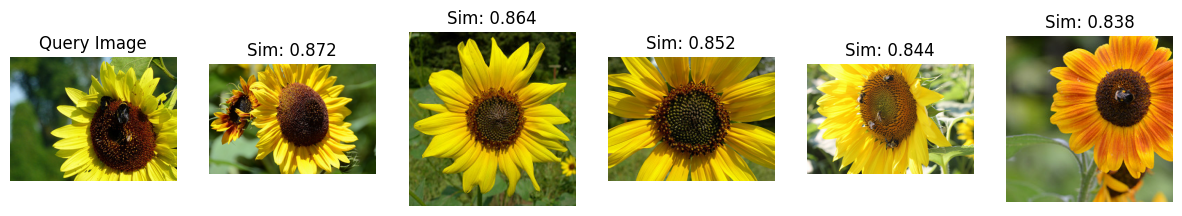

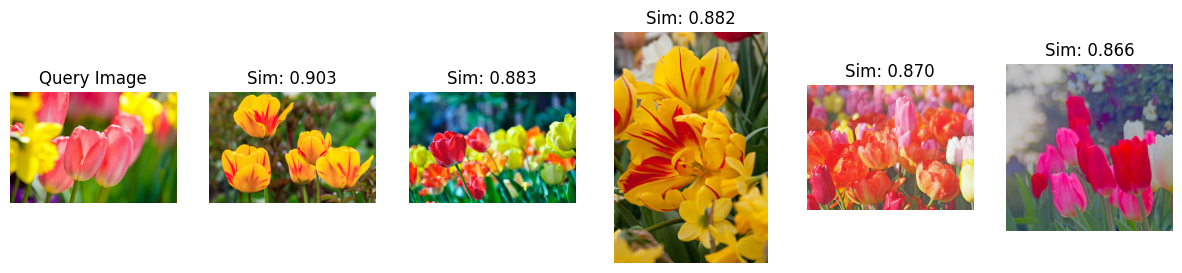

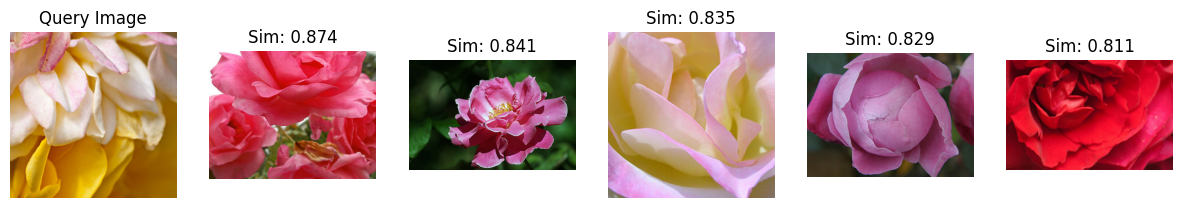

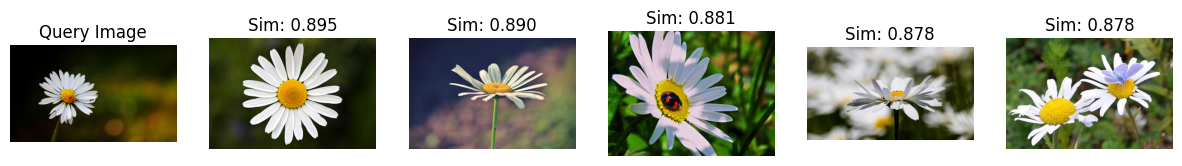

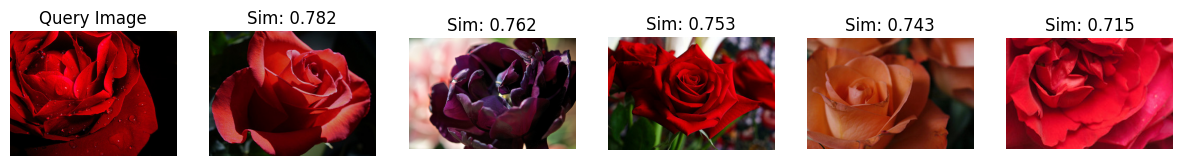

In [28]:
# Выбираем 5 случайных изображений из тестовой выборки
np.random.seed(22)
query_images = np.random.choice([img_path for img_path, _ in test_data], size=5, replace=False)

# Визуализация результатов
for query_img in query_images:
    similar_images = find_similar_images(query_img)
    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(query_img))
    plt.title("Query Image")
    plt.axis("off")
    
    for i, (img_path, sim_score) in enumerate(similar_images.items(), start=2):
        plt.subplot(1, 6, i)
        plt.imshow(Image.open(img_path))
        plt.title(f"Sim: {sim_score:.3f}")
        plt.axis("off")
    
    plt.show()